# Aggregate as globals to plot over time

Requires:
- A time-series of VTK files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import os, subprocess
import pickle
from natsort import natsorted

In [2]:
REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

In [3]:
## Pyvista global settings
pv.set_plot_theme("document")
pv.set_jupyter_backend('static')
#pv.set_jupyter_backend('ipygany')
pv.global_theme.transparent_background = False
pv.global_theme.show_scalar_bar = True

## Elliot-Brooks phi
hydCond = 1.3E-3
head_m  = 2.39E-4
bed_wavelenght = 0.15
depth_bed = 0.20
channel_width = 0.29
porosity = 0.33
Axy = bed_wavelenght*channel_width

In [4]:
def retriveAggregated(pathFolder,fieldKeys):
    '''
    fieldKeys = list of fields to aggregate

    Returns: dict(np.array)
    '''
    vtkFiles = natsorted([f for f in os.listdir(pathFolder) 
                        if os.path.isfile(os.path.join(pathFolder,f)) 
                        and os.path.splitext(os.path.join(pathFolder,f))[-1] == '.vtk' ])
    
    numberOfFiles = len(vtkFiles)

    vtkFile = vtkFiles[0]
    vtkPath = os.path.join(pathFolder,vtkFile)

    grid = pv.read(vtkPath)
    sized0 = grid.compute_cell_sizes()
    sized0.set_active_scalars('Volume',preference='cell')

    totalDict = {k:np.zeros(numberOfFiles) for k in fieldKeys}

    for i,f in enumerate(vtkFiles):
        vtkPath = os.path.join(pathFolder,f)
        grid = pv.read(vtkPath)
        for k in fieldKeys:
            totalDict[k][i] = np.sum(sized0['Volume'] * grid[k])/Axy  # kg/m²
    
    return totalDict

In [5]:
biomassKeys = ['XAR','XN','XDN','EPS','XI']
isHot = False

if (isHot):
    rasFolder = "/home/edsaa/nuModel/tempBioreactions/2.0NonZeroRANS/2.0NonZeroInitCondition/VTK/"
    lesFolder = "/home/edsaa/nuModel/tempBioreactions/2.1LES/2.1NonZeroLESRun/VTK/"
else:
    rasFolder = "/home/edsaa/nuModel/tempBioreactions/2.3ZeroStartRANS/2.3ZeroRANS/VTK/"
    lesFolder = "/home/edsaa/nuModel/tempBioreactions/2.2ZeroLES/2.2ZeroLES/VTK/"



In [6]:
rasTotalBiomass = retriveAggregated(rasFolder,biomassKeys)
lesTotalBiomass = retriveAggregated(lesFolder,biomassKeys)

In [7]:
endTime = min(len(rasTotalBiomass['XAR']),len(lesTotalBiomass['XAR'])) - 1

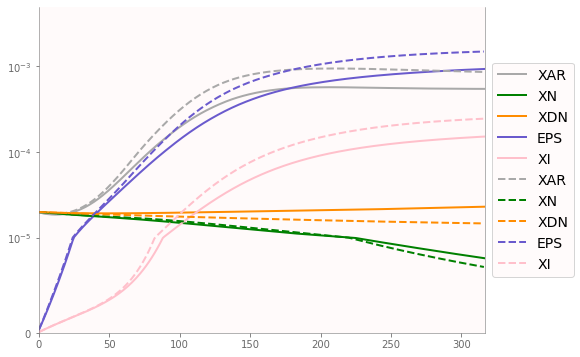

In [8]:
bcol = {k:v for k,v in zip(biomassKeys,['darkgrey','green','darkorange','slateblue','pink'])}

fig,ax = plt.subplots(figsize=[8,6])

for k,v in rasTotalBiomass.items(): ax.plot(v[1:],label=k,c=bcol[k])
for k,v in lesTotalBiomass.items(): ax.plot(v[1:],label=k, ls='dashed',c=bcol[k])

ax.legend(loc='center left',bbox_to_anchor=[1,0.5])
ax.set_yscale('symlog',linthresh=1E-5)
ax.set_ylim([0,5E-3])
ax.set_xlim([0,endTime])
plt.show()

In [9]:
endRasTotalBiomass = {k:v[endTime] for k,v in rasTotalBiomass.items()}
endLesTotalBiomass = {k:v[endTime] for k,v in lesTotalBiomass.items()}

In [10]:
#endTotalBiomass = {k:np.array([rasTotalBiomass[k][endTime],lesTotalBiomass[k][endTime]]) for k in biomassKeys}

In [11]:
endRasTotalBiomass

{'XAR': 0.0005472165465386879,
 'XN': 7.848633029110877e-06,
 'XDN': 2.3022539756192904e-05,
 'EPS': 0.0009348465870897025,
 'XI': 0.00015165017402073567}

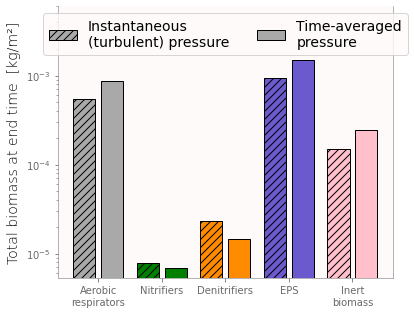

In [37]:
fig,ax = plt.subplots(figsize=(6,5),facecolor='w')
xpositions = np.arange(0,5)

ax.bar(xpositions-0.22,endRasTotalBiomass.values(),color=bcol.values(), label='Instantaneous\n(turbulent) pressure',
       width=0.35, hatch="///",edgecolor='black', log=True)
ax.bar(xpositions+0.22,endLesTotalBiomass.values(),color=bcol.values(), label='Time-averaged\npressure',
       width=0.35, edgecolor='black', log=True)

labels_barplot = ['Aerobic\nrespirators','Nitrifiers','Denitrifiers','EPS','Inert\nbiomass']
ax.set_xticks(xpositions, labels=labels_barplot)

ax.legend(ncol=2,loc='upper center',bbox_to_anchor=(0.5,1))

#ax.set_yscale('symlog',linthresh=0.1E-5)
ax.set_ylim(top=6E-3)
ax.set_ylabel(r"Total biomass at end time  [kg/m²]")

fileForSVG = f"AggregateData/{isHot=}_{endTime=}_Biomass.svg"
plt.savefig(fileForSVG)

# fileForPNG = f"AggregateData/{isHot=}_{endTime=}_Biomass.png"
# plt.savefig(fileForPNG)
# os.system(f"xclip -se c -t image/png -i {fileForPNG}")
plt.show()